<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_SS21/blob/main/week09/DCGAN_face_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs)
In our previous lecture on unsupervised neural networks and generative models we have encountered one generative model, namely the vartiational autoencoder (VAE), and only briefly outlined generative adversarial networks (GANs). Due to the immense popularity of the method, we are now coming back to the latter.

We will get to know GANs on a dataset containing celebrity faces called CelebA: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html that was first introduced at ICCV2015. 

The code in this notebook is heavily inspired, adapted and partially taken from the great PyTorch beginner tutorial on GANs: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## GANs
GANs were originally proposed by Ian Goodfellow et. al in their analogously called NeurIPS 2014 paper: https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf 

The general idea behind them is that we have two neural network models. On the one hand, we have a Generator G that is trying to generate images from a randomly sampled latent code z. On the other hand, we have a Discriminator D that is conducting a binary classification between images from a real dataset and the images generated by G. 

The idea behind training is to play a min-max game by training the discriminator to separate real from fake images and at the same time training the generator to fool the discriminator into believing its images are real. In other words,  if D(G(z)) is the probability that a generated image is a real image and D(x) the probability that an image from the dataset is considered as real, then the following loss function is to be optimized: 

$min_G max_D V(D,G)=𝔼_{x \sim p_{data}(x)}\left[ \log{D(x)} \right]+𝔼_{z \sim p_{z}(z)} \left[\log{(1−D(G(z)))} \right]$

Here, G tries to minimize the probability that D predicts its output as fake (as indicated by the 1 - term) and D tries to maximize its probability of separating real from fake images correctly. 

After training, the ideal outcome would be that the generator produces images that are able to fool the discriminator into randomly guessing whether an image is real or fake. However, GANs are notoriously known to be unstable during training and much of the currenct research is focused on preventing collapse, smooth training and robustness to hyperparameters.

## Architectural similarity to VAE

We can see an architectural analogy of GANs to VAEs as the two separate architectural components are trained jointly in a VAE (although there is many more mathematical differences of course). The decoder in a VAE is essentially analogous to the GAN's generator that tries to capture the data distribution, draw samples from a latent space and generate an image. The VAE's encoder is architecturally similar to the GAN's discriminator, although the task here of course is to classify fake vs. real instead of approximating the posterior. 

Much of the newer research bridges GANs and VAEs and is creating hybrid models that combine the advantages of both methods. 

In [ ]:
import os
import sys
import zipfile
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import random
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## CelebA: celebrity face dataset

We will first download, and make the CelebA dataset ready: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html  for our use with PyTorch. 

If the recommended Dropbox download doesn't work we will resort to a Google Drive download script from the following GitHub gist: 
https://gist.github.com/charlesreid1/4f3d676b33b95fce83af08e4ec261822 . Alternatively you can download it by hand and upload it to Colab. 

We then proceed to extract the downloaded zip file and do some formatting to be usable with PyTorch dataloaders. 
Specifically, as we will be using PyTorch's "ImageFolder" dataloader that loads images from subdirectories, we extract the dataset into a subdirectory called "data/celebA"

In [ ]:
# CelebA images
!mkdir -p ./data/
if not os.path.exists('./data/celeba.zip'):
    !wget -N https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0 -O ./data/celeba.zip
    !unzip -qq ./data/celeba.zip -d ./data/

"""
def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

# TAKE ID FROM SHAREABLE LINK
file_id = "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
# DESTINATION FILE ON YOUR DISK
file_path = "celebA.zip"
print("Downloading...")
download_file_from_google_drive(file_id, file_path)
print("Download successful")

save_root = 'data/'
if not os.path.isdir(save_root):
    os.mkdir(save_root)

print("Extracting zip...")
with zipfile.ZipFile(file_path) as zf:
    data_dir = zf.namelist()[0]
    zf.extractall(save_root)
    os.remove(file_path)
print("Extraction successful")

!mv data/img_align_celeba data/celebA
"""

Once the dataset is downloaded, extracted and the needed subdirectory is created, we can use PyTorch's image loading functionality to get the convenient dataset loader. 

Note that the images aren't square in size, so we will employ a common trick and resize all images' lower spatial dimension to 64 (with the other dimension being flexible and always larger) and then take center square crops of size 64 x 64 when training our neural network. Although we might lose some information in this process this prevents introduction of image distortions. As our images always contain faces at the center, the crop isn't much of an issue, but we could technically further introduce a dataset augmentation effect if we were to randomize these crops during training.  

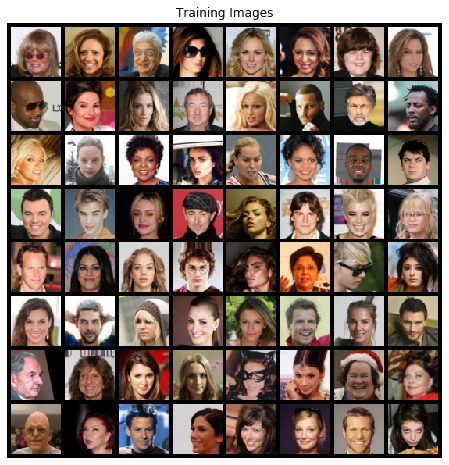

In [ ]:
image_size = 64 
dataset = torchvision.datasets.ImageFolder('./data/celeba', 
                                           transform=transforms.Compose([
                                               transforms.Resize(image_size), 
                                               transforms.CenterCrop(image_size),
                                               transforms.ToTensor(), 
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                           ]))

# Create the dataloader
batch_size = 128
workers = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64],
                                                    padding=5, normalize=True).cpu(),
                        (1, 2, 0)))

## Our GAN's architecture: DCGAN

There has been follow-up work on the original GAN paper that improves generation by using convolutional neural networks and applies a couple of additional tricks to make training smoother. As we are already familiar with CNNs we will directly proceed with such a variant of GANs referred to as DCGAN: https://arxiv.org/pdf/1511.06434.pdf . 

The main differences to the original paper are:

* use of convolutions in Generator G and Discriminator D
* inclusion of batch normalization layers after activation functions that allow for more stable training. You can read up on batch normalization in the respective paper: https://arxiv.org/abs/1502.03167
* LeakyReLUs in the discriminator that have an additional negative slope for values below 0: https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU 
* Strided convolutions instead of pooling so that the network can learn more complex down or upsampling behavior by itself

The architecture of G and D are illustrated nicely in the following diagram. We will need to implement the code for G and D below.

![](https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_DCGAN.png?raw=true) (figure from: https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_DCGAN.png?raw=true)

Another crucial contribution of the DCGAN paper is the proposal of hyper-parameters that are very relevant to the stability of training. This specifically includes:

* normalization of the data to the range -1 and +1 (as already implemented in above data loader transformations). Correspondingly a tanh function is used at the output of the generator. 
* a specific weight initialization scheme from a Normal distribution with mean=0 and standard deviation=0.02 for all layers. This is fundamentally different from the weight initialization techniques that we have previously encounterd that typically scale the standard deviation based on a layer's width. 

**To speed up the computation we will make all layers half as wide as specified in above graph and the original DCGAN. This way we can get results in a reasonable amount of time that still look appealing enough. As we are nearing the end of this course, this is a good exercise to learn how to implAement something according to the discreption provided in a paper. Let's implement G and D.**


In [ ]:
# Implement the Generator here according to the architecture diagram above.

# Use padding = 0 (the fifth argument of ConvTranspose2d) in the first 
# transposed convolution (ConvTranspose2d) and 1 in all others 

# Remember that batch norm comes before the ReLU

# for debugging purposes the state sizes are indicated at each block

# set the bias=False everywhere. 

# Build the network using a sequential container. Simply specify the layer
# and add the next one, separated by a comma. You don't need to change the 
# forward function

# don't forget the tanh

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        self.gen = nn.Sequential(
            # input is Z, going into a convolution
            
            
            # first block here
            # state size: 512 x 4 x 4
            
            # second block here
            # state size: 256 x 8 x 8
            
            # third block here
            # state size: 128 x 16 x 16
            
            # fourth block
            # state size: 64 x 32 x 32
            
            # last block, ending on an image
            # state size: 3 x 64 x 64
        )

    def forward(self, input):
        return self.gen(input)

In [ ]:
# build the discriminator according to the above diagram. 

# Remember the subletly that the first block is an embedding and doesn't have 
# a batch norm layer. 

# use the LeakyReLU as indicated above. The PyTorch syntax is 
# nn.LeakyRelu(value, inplace=True), where value is the negative slope.

# Build the network using a sequential container. Simply specify the layer
# and add the next one, separated by a comma. You don't need to change the 
# forward function

# don't forget the Sigmoid

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input is 64 x 64 x 64
            # first block
            # state size: 64 x 32 x 32
            
            # second block
            # state size: 128 x 16 x 16
            
            # third block
            # state size: 256 x 8 x 8
            
            # fourth block
            # state size. 512 x 4 x 4
            
            # last block ending on classifier
        )

    def forward(self, input):
        return self.disc(input)

In [ ]:
# our custom weights initialization that we need to call on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Create our generator and discriminator and initialize them with our custom weight initialization function.

In [ ]:
# Create the generator with a latent dimensionality of 100
netG = Generator(100).to(device)

# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to both networks
netG.apply(weights_init)
netD.apply(weights_init)

# Print the GAN
print(netG)
print(netD)

## Training the GAN

We already know a suitable loss function to optimize the networks' log likelihoods: the binary cross entropy loss (called BCELoss in PyTorch.

$ℓ(x,y) = L = \{l_1,…,l_N\}^{T}, \quad l_n = −\left[y_n \log{x_n}+(1−y_n) \log{(1−x_n)}\right]$

If we set our labels correspondingly we can use the same function for both G and D as the loss already contains a 1 minus term. The convention that is typically used for this is to set the labels of the real images to 1 and those of the fake images to 0. 

Once we have done this, we can create the two optimizers for the parameters of G and D respectively. 

To monitor our training progress we also sample a *fixed* mini-batch of latent vectors. We can use this fixed noise to generate images using G at different stages of training to visually gauge our progress. Note that this is not a formally correct way to estimate how good a GAN is performing. There is several metrics that have been proposed in the literature to gauge the quality of GAN. However, as we cannot simply compute the log-likelihood of the data as with the VAE, there is much research that is still being conducted in this direction and it is very much an open research question. 

In [ ]:
# Learning rate for the optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Initialize BCELoss function
criterion = nn.BCELoss()

# Sample a mini-batch latent vectors that we will use to 
# visualize the progression of the generator
fixed_noise = torch.randn(64, netG.latent_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training loop

Let's write our updates for the different parts.

Generally, there is two parts to the optimization:

1. Training the discriminator, i.e. maximizing the probability of correctly classifying real vs. fake. We can do this in two parts, first on real images and then on fake images, and accumulate the gradients before conducting an update.
2. Training the generator, i.e. minimizing 1 - D(G(z)). The original paper by Goodfellow et. al shows how maximizing D(G(z)) instead seems to provide better gradients. A trick is thus to also maximize here (i.e. not using the 1 minus term but relying on the log(x) part) using the label 1(as if it were a real label) instead of using the 1 minus part with a label of 0. 

What we will need is to implement this update logic now in seprate steps:

1. Forward D with real images
2. Calculate loss and gradients of D with real images
3. Generate fake images from G
4. Forward D with fake images
5. Compute loss and gradients of D with fake images
6. Sum losses, gradients of fake and real images
7. Update weights of D
8. Forward all fake images of G through D again
9. Calculate loss and gradients for G
10. Update G

Let us implement these steps in the training loop below. As previously mentioned GANs are difficult to evaluate and we cannot simply use a validation set or similar to evaluate how well our GAN is doing. 

**It is strongly recommended to start training with 1 epoch only with a GPU runtime to debug before proceeding to train the GAN fully. If you don't see something that resembles (smudgy) faces, there is something wrong with your code. After you have confirmed that your code is working try training for a minimum of 5 epochs (this will take roughly 20 minutes) to see some more compelling results.**

In [ ]:
# Training Loop
num_epochs = 5

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        label = torch.full((real_cpu.size(0),), real_label, device=device).float()
        
        # Forward pass real batch through D
        output = ...
        
        # Calculate loss on real image mini-batch
        errD_real = ...
        
        # Calculate gradients for D in backward pass
        ... # D backward here
        D_x = output.mean().item()

        ## Train with mini-batch consisting of fake images
        # Generate mini-batch of latent sample vectors
        # note that we need an extra 1, 1 dimensionality for spatial dimensions
        # use torch.randn to draw from a normal distribution.
        # don't forget to cast the noise mini-batch to device
        noise = ...
        
        # Generate fake image batch with G
        fake = ...
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = ...
        # Calculate D's loss on the all-fake batch
        errD_fake = ...
        # Calculate the gradients for this batch
        ... # backward D here 
        
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        ... # do the optimizer step on D

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # use trick described in text above: use real labels
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = ...
        # Calculate G's loss based on this output
        errG = ...
        # Calculate gradients for G
        ... # backward G
        
        D_G_z2 = output.mean().item()
        # Update G
        ... # do the optimizer step on G
        
        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

## Visualization

Let us visualize the progress of our losses, and our generations from the fixed noise vector 

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

 Progress of fixed latent vector generations

In [ ]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64],
                                                    padding=5, normalize=True).cpu(),
                        (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()